In [33]:
from polygon import RESTClient
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

class SimpleMovingAverage:
  def __init__(self, typ, period):
    self.period = period
    self.typ = typ
    self.data = []
    self.avg = -1 # needs updating - at least 1 day(s) of data required
  
  def update(self, new_delta):
    if self.typ == "gain" and new_delta < 0:
      new_delta = 0
    elif self.typ == "loss" and new_delta > 0:
      new_delta = 0
    self.data.append(abs(new_delta))
    if len(self.data) > self.period:
      self.data.pop(0)
    self.avg = sum(self.data) / len(self.data)
  

class RelativeStrengthIndex:
  def __init__(self, period=14):
    self.period = period
    self.last = -1
    self.rsi = -1 # needs updating - more than [period=14] day(s) of data required
    self.count = 0
    self.gain_avg = SimpleMovingAverage("gain", period)
    self.loss_avg = SimpleMovingAverage("loss", period)
  
  def update(self, new_data_point, time=""):
    if self.last >= 0:
      self.gain_avg.update(new_data_point - self.last)
      self.loss_avg.update(new_data_point - self.last)
    self.last = new_data_point
    self.count += 1
    if self.count > self.period:
      self.rsi = 100 - (100 / (1 + self.gain_avg.avg / self.loss_avg.avg))

client = RESTClient("InxdvvQ5aFMwk5xWUpJUCpe8YHcimh8d")

def generate_date_array(year):
    dates = []
    # Start from the first day of the given year
    current_date = datetime(year, 1, 1)
    # End on the last day of the given year
    end_date = datetime(year + 1, 1, 1)
    
    while current_date < end_date:
        # Format the date as "yyyy-mm-dd" and add it to the list
        date_string = current_date.strftime("%Y-%m-%d")
        dates.append(date_string)
        # Move to the next day
        current_date += timedelta(days=1)
    
    return dates

def graph_profits(data, type_of_profit):
    # Extract keys and values
    dates = list(data.keys())
    values = list(data.values())

    # Convert string dates to datetime objects
    dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

    # Create a plot
    plt.figure(figsize=(8, 4))
    plt.plot(dates, values, marker='o', linestyle='-', color='b')

    # Format the x-axis to show dates properly
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())

    # Label the axes
    plt.xlabel('Date')
    plt.ylabel(type_of_profit)
    plt.title(f'Model {type_of_profit} vs Holding Stock')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()

def run_simulation(ticker, day, init_cash, init_shares, percent_invest, prices, times, buys, sells):
  transaction_times = sorted(buys + sells)
  transactions = []
  for t in transaction_times:
    price = prices[times.index(t)]
    if t in buys:
      transactions.append([t, price, "Buy"])
    else:
      transactions.append([t, price, "Sell"])
  # Execute Transactions through simulation
  cash = init_cash
  shares = init_shares
  print("Running Simulation for RSI with", ticker, "on", day)
  print("Number of Transactions: ", len(transactions))
  print("Buys: ", len(buys), "Sells: ", len(sells))
  print("Open Price, Close Price: ", prices[0], prices[-1])
  print("BOD Cash and Shares: ", cash, shares)
  portfolio_val_s = cash + prices[0] * shares
  print("BOD Portfolio Value: ", portfolio_val_s)
  amt = cash * percent_invest / 100
  for order in transactions:
    if order[2] == "Buy":
      cash -= amt
      shares += amt/order[1]
    else:
      cash += amt
      shares -= amt/order[1]
  print("EOD Cash and Shares: ", cash, shares)
  portfolio_val_e = cash + prices[-1] * shares
  profit = portfolio_val_e - portfolio_val_s
  profit_percentage = (portfolio_val_e - portfolio_val_s) / portfolio_val_s * 100

  base_profit_percentage = init_shares*(prices[-1]-prices[0])/portfolio_val_s * 100

  print("EOD Portfolio Value: ", portfolio_val_e)
  print("Model Profit Percentage: ", profit_percentage)

  print("Market Change w/o trades", base_profit_percentage)
  print("Model outperforms market by", (profit_percentage - base_profit_percentage), "%") 


  return [cash, shares, profit, profit_percentage, base_profit_percentage]


In [34]:
def invest_rsi(ticker, day, cash=100000, shares=1000, percent_invest=20):
  aggs = client.get_aggs(ticker, 1, "minute", day, day)
  x_close = []
  y_close = []
  min_diff = 1
  for i in range(0, len(aggs), min_diff):
    agg = aggs[i]
    x_close.append(datetime.fromtimestamp(agg.timestamp // 1000).time().strftime("%H:%M"))
    y_close.append(agg.close)

  
  #check if there is data for this day
  if len(y_close) == 0:
    print("no data for this day and stock")
    return(cash, shares, 0, 0, 0)

  # RSI execution
  data_x = []
  data_y = []
  low = []
  high = []
  rsi = RelativeStrengthIndex()
  last_rsi = -1
  buys = []
  sells = []
  for time, point in zip(x_close, y_close):
    rsi.update(point, time)
    if rsi.count > rsi.period:
      if last_rsi < 0:
        last_rsi = rsi.rsi
      data_x.append(time)
      data_y.append(rsi.rsi)
      low.append(30)
      high.append(70)
      if last_rsi < 30 and rsi.rsi >= 30:
        buys.append(time)
      if last_rsi > 70 and rsi.rsi <= 70:
        sells.append(time)
      last_rsi = rsi.rsi

  return run_simulation(ticker, day, cash, shares, percent_invest, y_close, x_close, buys, sells)


In [37]:
def test_model(ticker, start_date, end_date, init_cash, init_shares, percent_invest):
    year1 = int(start_date[:4])
    year2 = int(end_date[:4])
    date_array = []
    for year in range(year1, year2+1):
        date_array += generate_date_array(year)

    alphas = []
    alphas_dict = {}
    profits_dict = {}
    start_d_idx = date_array.index(start_date)
    end_d_idx = date_array.index(end_date)
    cash = init_cash
    shares = init_shares

    for date in date_array[start_d_idx: end_d_idx+1]: #has to be 4 because 
        print(date)
        cash, shares, profit, profit_percentage, base_profit_percentage = invest_rsi(ticker, date, init_cash, init_shares, percent_invest)
        alphas.append(alpha:=(profit_percentage-base_profit_percentage))
        profits_dict[date] = profit_percentage
        alphas_dict[date] = alpha
        print()

    print(alphas_dict)

    return alphas_dict, profits_dict

#test but only 4 days allowed in free API
alphas_dict, profits_dict = test_model("AMZN", "2023-01-11", "2023-01-14", 100000, 1000, 20) 

2023-01-11
Running Simulation for MACD with AMZN on 2023-01-11
Number of Transactions:  45
Buys:  14 Sells:  31
Open Price, Close Price:  90.07 95.13
BOD Cash and Shares:  100000 1000
BOD Portfolio Value:  190070.0
EOD Cash and Shares:  440000.0 -2650.4886547039123
EOD Portfolio Value:  187859.01427801684
Model Profit Percentage:  -1.1632481306798343
Market Change w/o trades 2.662177092650077
Model outperforms market by -3.8254252233299115 %

2023-01-12
Running Simulation for MACD with AMZN on 2023-01-12
Number of Transactions:  51
Buys:  15 Sells:  36
Open Price, Close Price:  95.09 95.28
BOD Cash and Shares:  100000 1000
BOD Portfolio Value:  195090.0
EOD Cash and Shares:  520000.0 -3385.579958770205
EOD Portfolio Value:  197421.94152837485
Model Profit Percentage:  1.1953157662488354
Market Change w/o trades 0.09739094776769579
Model outperforms market by 1.0979248184811397 %

2023-01-13
Running Simulation for MACD with AMZN on 2023-01-13
Number of Transactions:  51
Buys:  20 Sells:

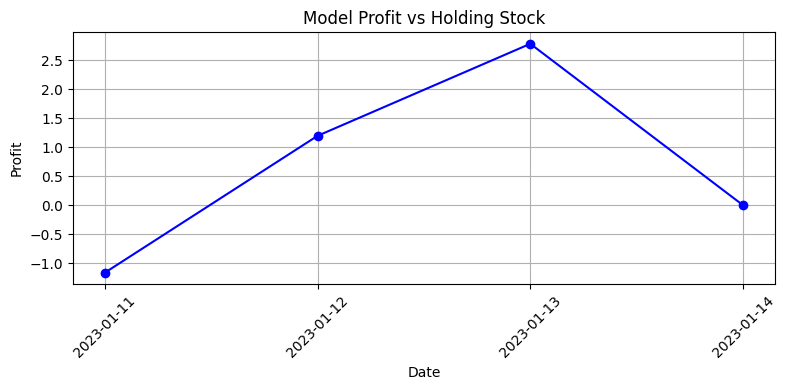

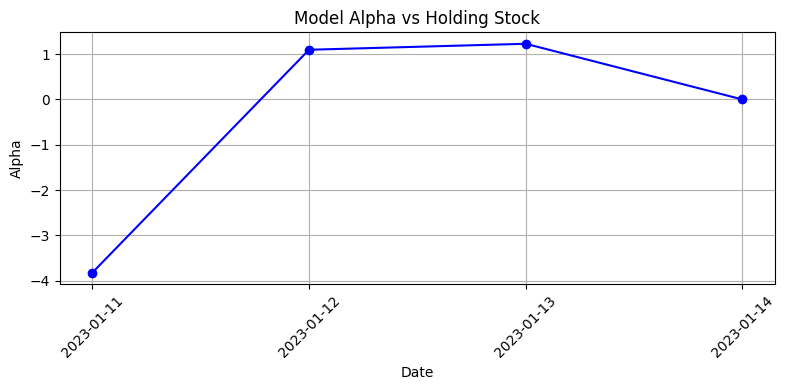

Average Profit: 0.7034024798420976
Average Alpha: -0.3744139426144736


In [39]:
graph_profits(profits_dict, "Profit")
graph_profits(alphas_dict, "Alpha")
print(f"Average Profit: {sum(profits_dict.values())/len(profits_dict.values())}")
print(f"Average Alpha: {sum(alphas_dict.values())/len(alphas_dict.values())}")